In [174]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathurinache/3t-fmri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/3t-fmri-dataset


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Multiply,Reshape
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time

In [5]:
# Let's load some other packages we need
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib # common way of importing nibabel

In [177]:
mri_file = '/kaggle/input/3t-fmri-dataset/ds003477/sub-03/ses-1/fmap/sub-03_ses-1_dir-face_run-1_epi.nii'#'anat.nii.gz'
img = nib.load(mri_file)

In [178]:
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


In [179]:
print(img.shape)

(80, 80, 44, 3)


In [180]:
hdr = img.header
hdr.get_zooms()

(2.7, 2.7, 2.97, 0.7)

In [181]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.memmap'>
(80, 80, 44, 3)


In [182]:
# printing a small 3x3x3 volume of voxels from the first timepoint
print(img_data[38:41, 38:41, 20:23, 0])

[[[22191.54296875 46924.1015625  63927.73828125]
  [25304.2890625  38326.99609375 59840.9375    ]
  [26892.42382812 32567.359375   56897.59375   ]]

 [[20899.859375   47792.28515625 60814.9921875 ]
  [18485.89453125 43769.0078125  58528.078125  ]
  [20412.83203125 49105.140625   57363.4453125 ]]

 [[35913.03125    41736.1953125  58019.875     ]
  [39152.828125   44425.4375     59480.95703125]
  [42011.47265625 49168.66796875 62805.453125  ]]]


Shape of slice: (80, 44)


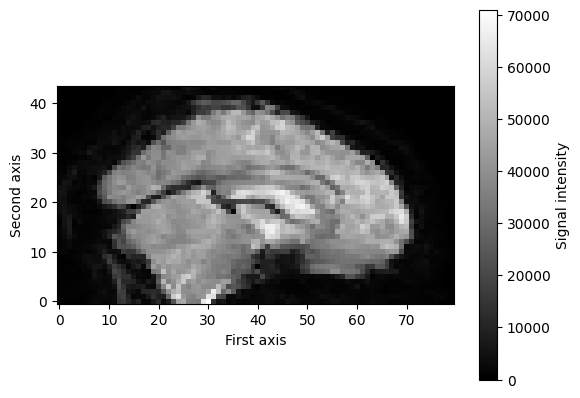

In [183]:
mid_slice_x_fmri = img_data[39, :, :, 0]  # x = 39, t = 0
print("Shape of slice: %s" % (mid_slice_x_fmri.shape,))

plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

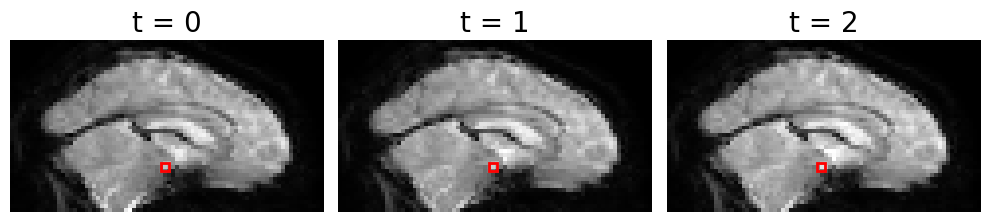

In [184]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 20))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(img_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((38, 10), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()

Voxel timeseries shape: (3,)


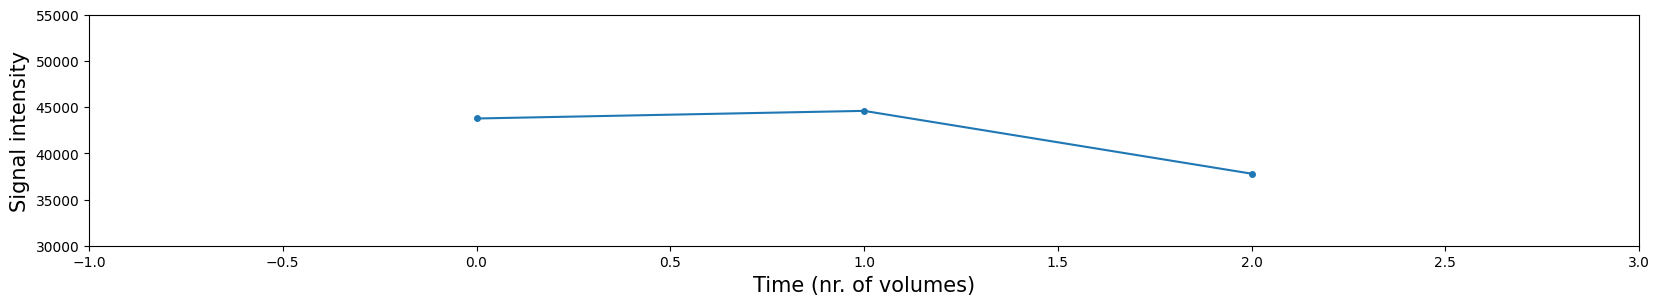

In [185]:
mid_vox_ts = img_data[39, 39, 21, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))
plt.figure(figsize=(20, 3))
plt.plot(mid_vox_ts, 'o-', ms=4)
plt.xlim(-1, mid_vox_ts.size)
plt.ylim(30000, 55000)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.show()

In [6]:
# import some stuff if you haven't done that already
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline

In [7]:
mri_file = '/kaggle/input/3t-fmri-dataset/ds003477/sub-03/ses-1/func/sub-03_ses-1_task-face_acq-Mb4Mm27Tr700_run-1_bold.nii'#'anat.nii.gz'
img = nib.load(mri_file)
print(img.shape)
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!

(80, 80, 44, 342)
<class 'numpy.memmap'>


In [8]:
mid_vox_ts = img_data[39, 39, 21, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))


Voxel timeseries shape: (342,)


In [75]:
normalized_data = (mid_vox_ts - mid_vox_ts.min(axis=0)) / (mid_vox_ts.max(axis=0) - mid_vox_ts.min(axis=0))
mid_vox_ts=normalized_data*40


Example of voxel signal


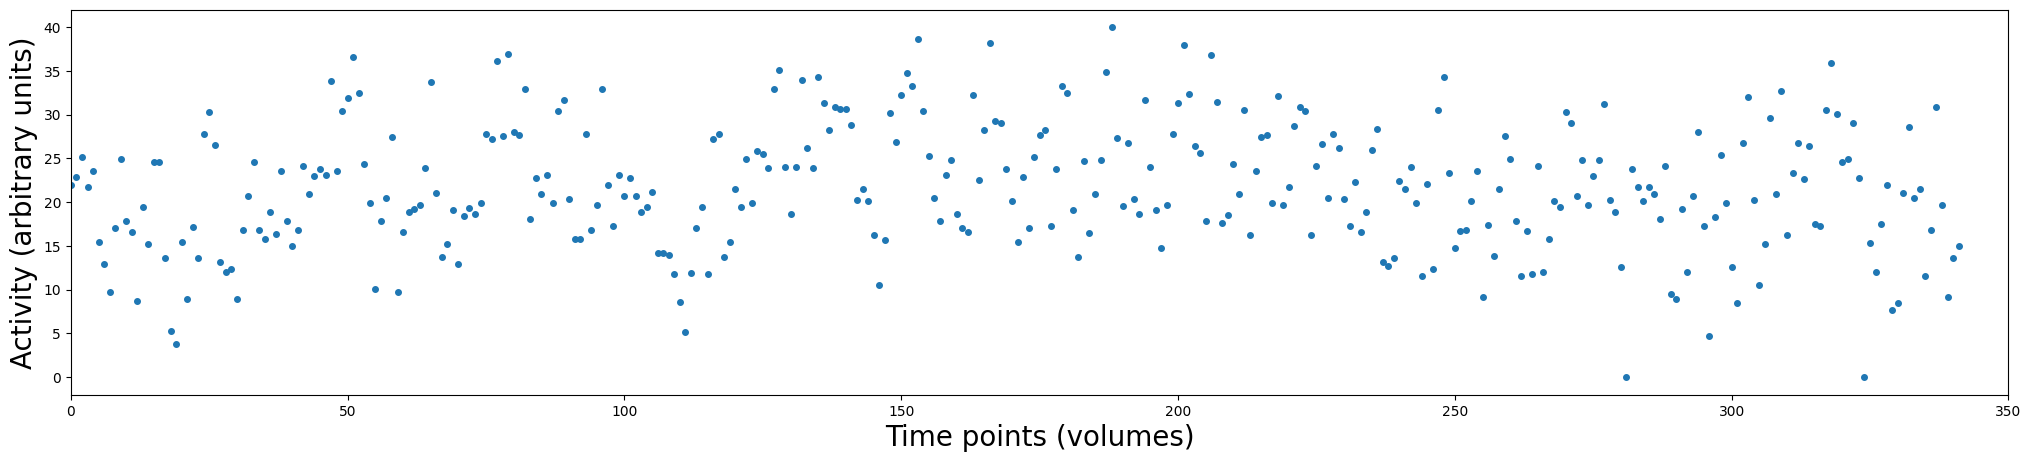

In [76]:
print('Example of voxel signal')
plt.figure(figsize=(25, 5))
plt.plot(mid_vox_ts, 'o', ms=4)
plt.xlim(0,350)
#plt.ylim(41000, 49000)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.show()

Example of voxel signal


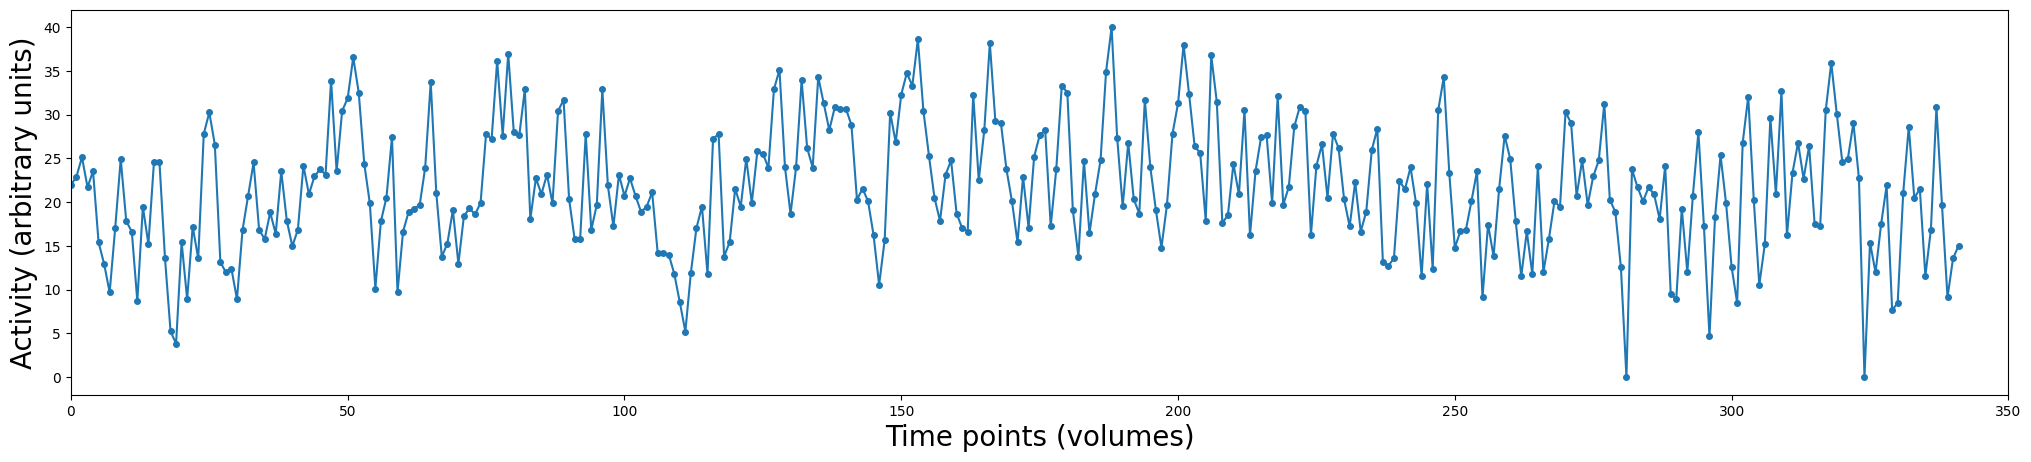

In [77]:
print('Example of voxel signal')
plt.figure(figsize=(25, 5))
plt.plot(mid_vox_ts, '-o', ms=4)
plt.xlim(0,350)
#plt.ylim(42500, 48000)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.show()

In [78]:
#stimulus 
onsets_squares = np.array([10, 110, 210], dtype=int)
onsets_circles = np.array([60, 160, 260], dtype=int)
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210  60 160 260]


In [79]:
onsets_squares = np.array([10, 110, 210, 310, 410, 510], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560], dtype=int)
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210 310 410 510  60 160 260 360 460 560]


In [80]:
predictor_all = np.zeros(600)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

print("Shape of predictor: %s" % (predictor_all.shape,))
print("\nContents of our predictor array:\n%r" % predictor_all.T)

Shape of predictor: (600,)

Contents of our predictor array:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 

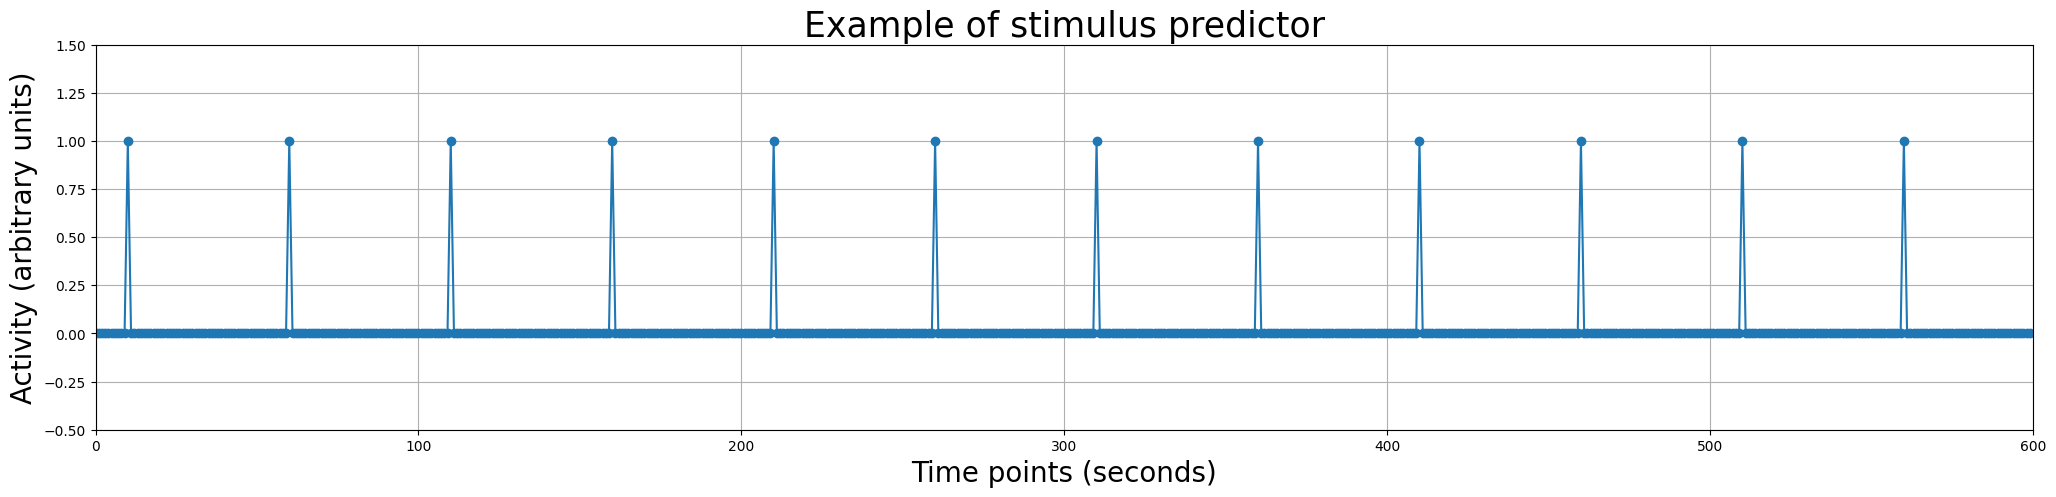

In [71]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 600)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

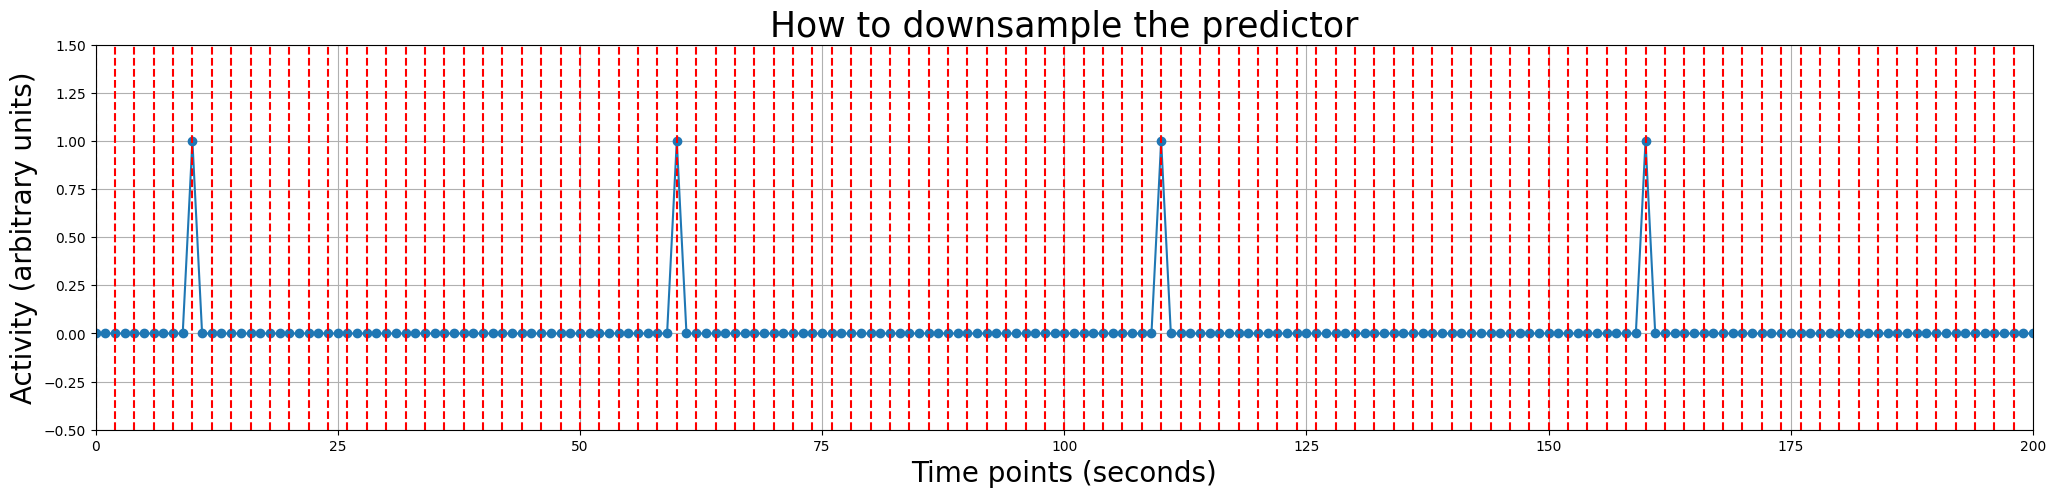

In [48]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=25)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

In [72]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 600, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-342, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 600, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 310, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 600 datapoints (0-342, in seconds)
Desired scale has 300 datapoints (0, 2, 4, ... 310, in volumes)
Downsampled predictor has 300 datapoints (in volumes)


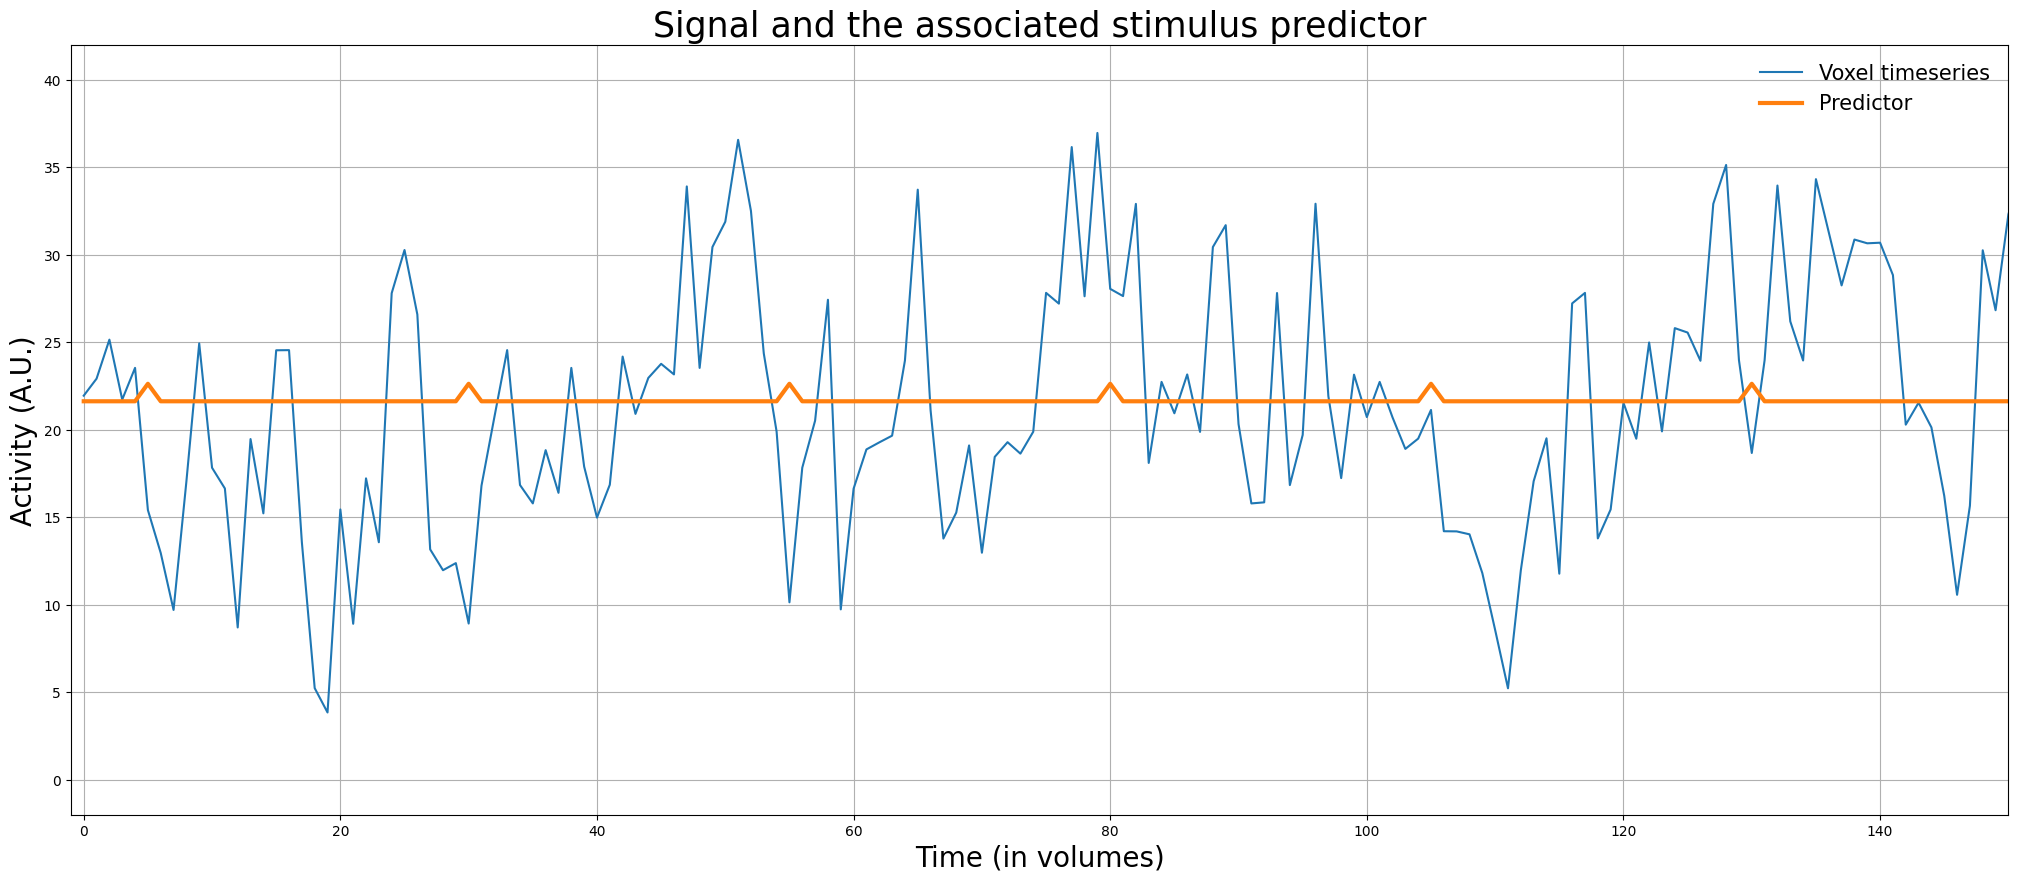

In [81]:
plt.figure(figsize=(25, 10))
plt.plot(mid_vox_ts)
plt.plot(predictor_all_ds + (mid_vox_ts).mean(), lw=3)
plt.xlim(-1, 150)
#plt.ylim(440,470)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

In [52]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from scipy.interpolate import interp1d

In [54]:
TR = 2
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 32


### In the above model, we have not incorporated either the lag (i.e. ~6 seconds) or the shape of the BOLD-response: we simply modelled activity as an instantaneous response to a stimulus event.

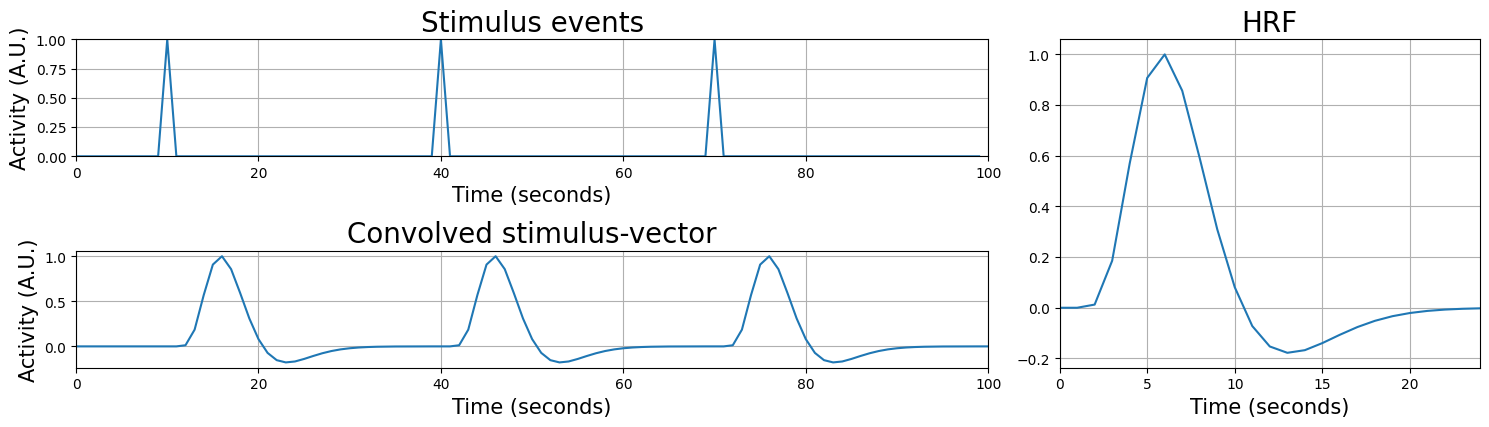

In [82]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf, 'full')
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

In [56]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (631,)
After trimming, the shape is: (600,)
Shape after adding the new axis: (600, 1)


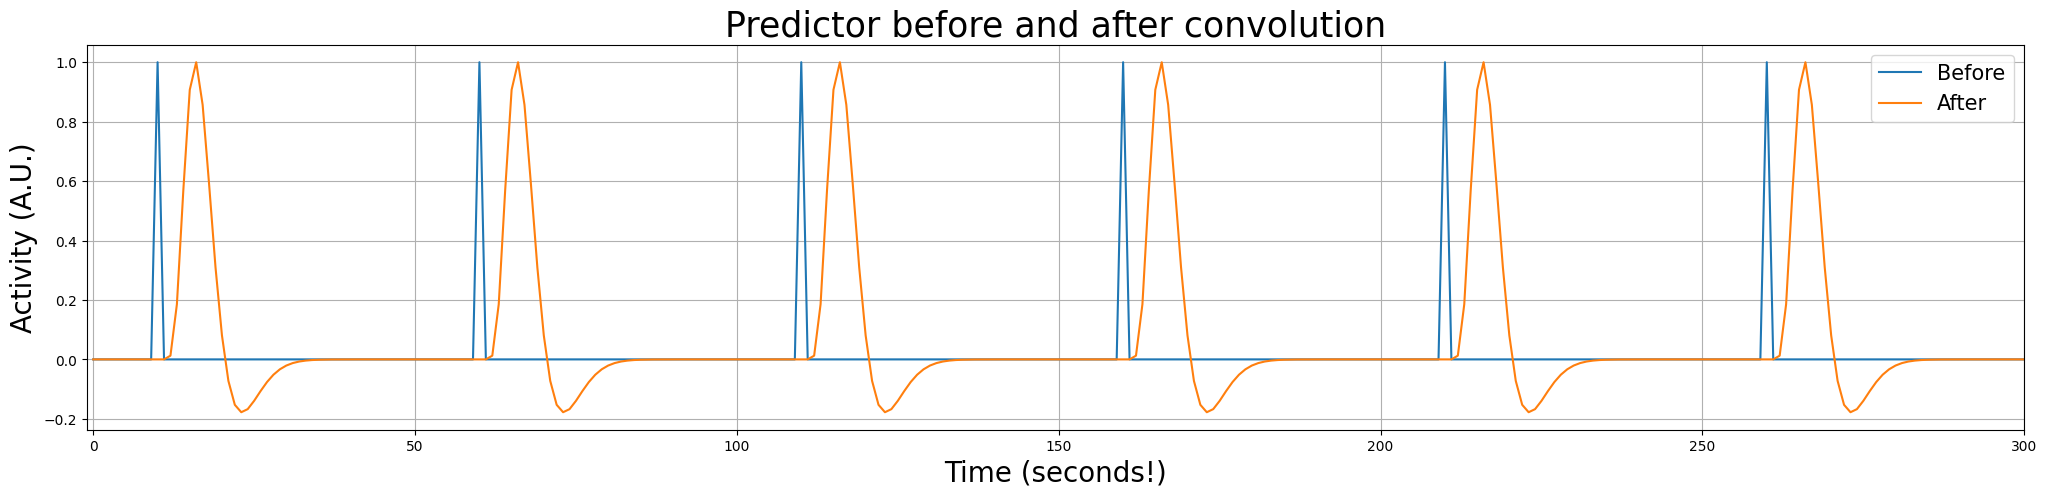

In [57]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 300)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

In [58]:
print("Size convolved predictor: %i" % predictor_conv.size)
print("Size voxel signal: %i" % mid_vox_ts.size)

Size convolved predictor: 600
Size voxel signal: 342


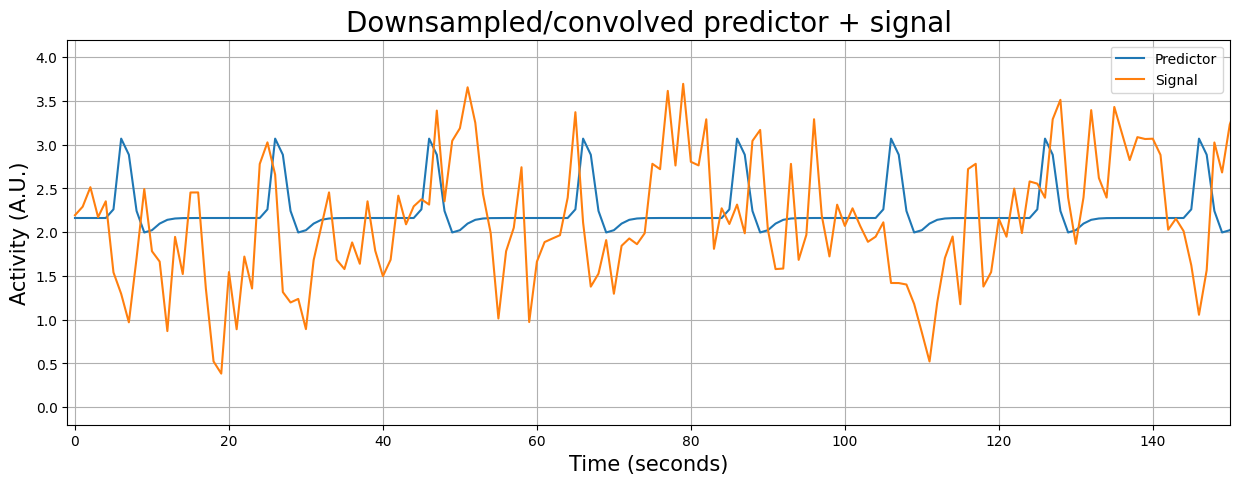

In [88]:
original_scale = np.arange(0, 600)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 600, 2.5)
predictor_conv_ds = resampler(desired_scale)

plt.figure(figsize=(15, 5))
plt.plot(predictor_conv_ds + (mid_vox_ts).mean())
plt.plot(mid_vox_ts)
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['Predictor', 'Signal'])
plt.xlim(-1, 150)
plt.show()

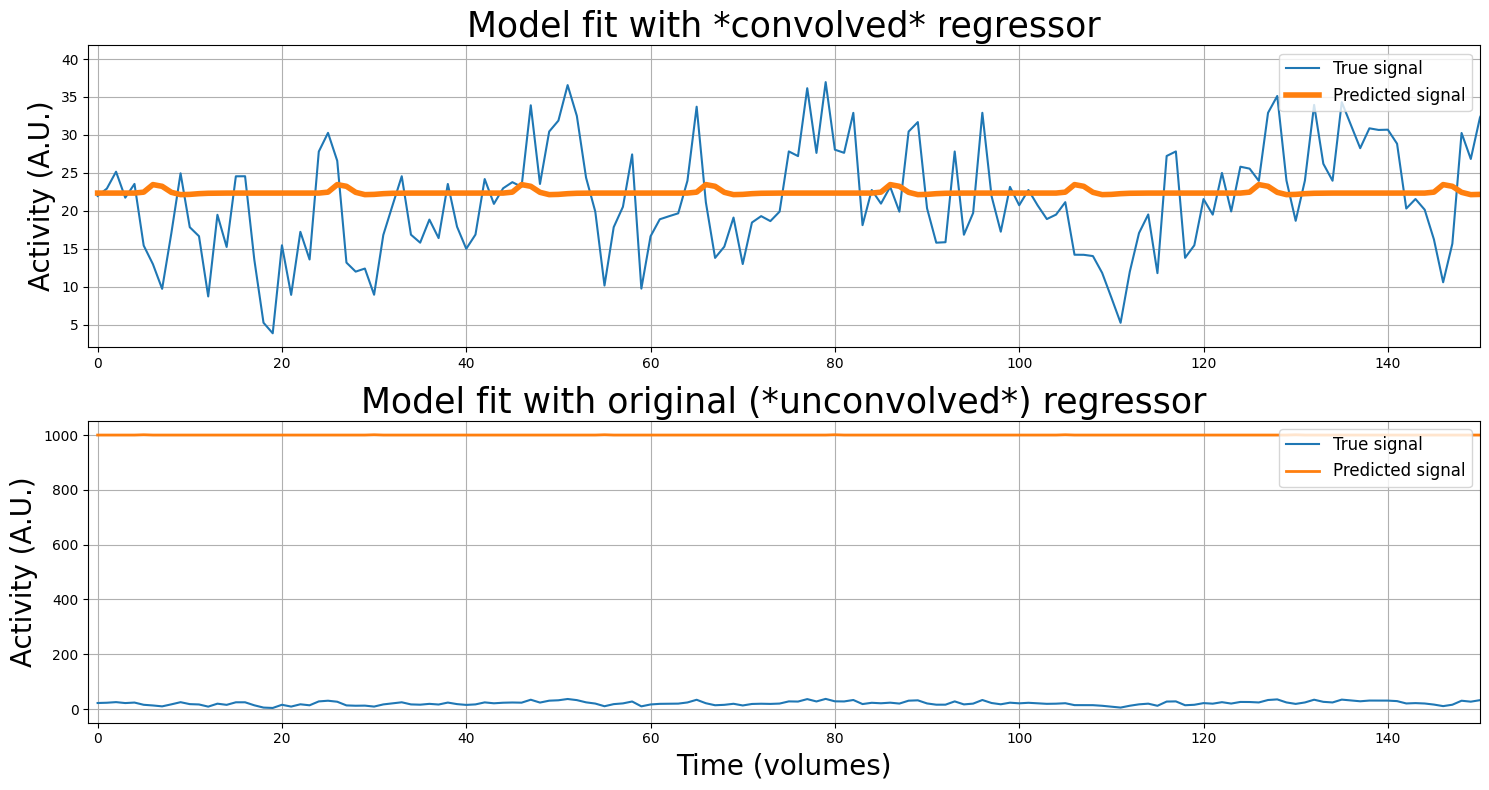

In [94]:
if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]

intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ (mid_vox_ts[:240])

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(mid_vox_ts[:240])
plt.plot(X_conv @ betas_conv, lw=4)
plt.xlim(-1, 150)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(mid_vox_ts[:300])
betas_simple = np.array([1000.64701684, 1.02307437])
icept = np.ones((predictor_all_ds[:, np.newaxis].size, 1))
X_simple = np.hstack((icept, predictor_all_ds[:, np.newaxis]))
plt.plot(X_simple @ betas_simple, lw=2)
plt.xlim(-1, 150)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()